In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [3]:
bureau = pd.read_csv('../input/bureau.csv', nrows=20000)
bb = pd.read_csv('../input/bureau_balance.csv', nrows=20000)

<font size=3> STATUS: 

Status of Credit Bureau loan during the month (active, closed, DPD0-30, ? )

C means closed

X means status unknown,

0 means no DPD, 

1 means maximal did during month between 1-30, 

2 means DPD 31-60,

? 5 means DPD 120+ or sold or written off

In [3]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [4]:
bb.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

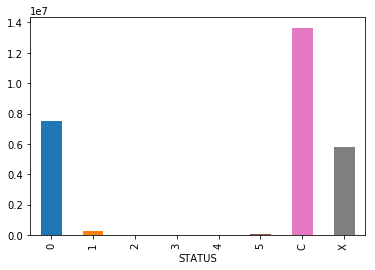

In [5]:
bb.groupby('STATUS').size().plot(kind='bar')

<font size=3> merely a tiny part of the bureau balance records are overdue.
So we decided to merge all overdue cates into one

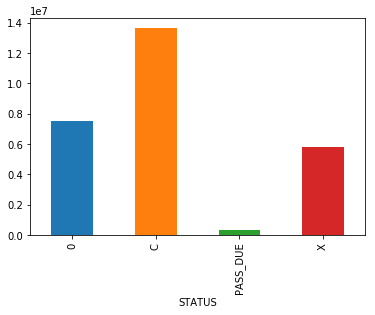

In [6]:
for i in range(1, 6):
    bb[bb['STATUS'] == str(i)] = 'PASS_DUE'
bb.groupby('STATUS').size().plot(kind='bar')

<font size=3> take a glimpse on some records

In [7]:
bb[bb['SK_ID_BUREAU'] == 6291463]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
15881597,6291463,0,C
15881598,6291463,-1,C
15881599,6291463,-2,C
15881600,6291463,-3,C
15881601,6291463,-4,C
15881602,6291463,-5,C
15881603,6291463,-6,C
15881604,6291463,-7,0
15881605,6291463,-8,0
15881606,6291463,-9,0


<font size=3> apprently this credit went go through 2 types of status.

In [8]:
def one_hot_encoding(df, nan_as_category):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [9]:
# manual feature - has status changed over the records?
def see_change(x):
    return x.nunique() > 1

bb_agg = bb.groupby('SK_ID_BUREAU')[['STATUS']].\
            agg(see_change).rename(columns={'STATUS': 'STATUS_CHANGE'}).astype('float')

# get the latest status for a certain bureau id
def find_lateset_status(df):
    # note that month balance is negative
    return df[df['MONTHS_BALANCE'] == df['MONTHS_BALANCE'].max()]['STATUS'].values[0]

latest_status = {}
for sk_id, sub_df in bb.groupby('SK_ID_BUREAU'):
    latest_status[sk_id] = find_lateset_status(sub_df)
bb_agg['LATEST_STATUS'] = pd.Series(latest_status)

<font size=4> see the distribution on LATEST_STATUS

In [10]:
bb_agg.groupby('LATEST_STATUS').size().plot(kind='bar')

In [ ]:
bb_agg, _ = one_hot_encoding(bb_agg, nan_as_category=True)

In [ ]:
bb, bb_cat = one_hot_encoding(bb, nan_as_category=True)
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

status_aggregations = {}
for col in bb_cat:
    status_aggregations[col] = ['mean', 'sum']

bb_agg_auto = bb.groupby('SK_ID_BUREAU').agg({**bb_aggregations, **status_aggregations})
bb_agg_auto.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg_auto.columns.tolist()])
bb_agg = bb_agg.join(bb_agg_auto, on='SK_ID_BUREAU', how='left')

In [ ]:
for col in bb_agg.columns:
    print(col)

In [ ]:
bb_cat = [col for col in bb_agg.columns if 'STATUS_CHANGE' not in col and 'MONTHS_BALANCE' not in col]

In [ ]:
bb_cat

<font size=5> Process Bureau

<font size=3>
SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed

CREDIT_ACTIVE, Status of the Credit Bureau (CB) **reported** credits,

CREDIT_CURRENCY, Recoded currency of the Credit Bureau credit,recoded

DAYS_CREDIT, How many days before current application did client apply for Credit Bureau credit,time only relative to the application

CREDIT_DAY_OVERDUE, Number of days past due on CB credit at the time of application for related loan in our sample,

DAYS_CREDIT_ENDDATE, Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application - Positive for the loan still not paid totally

DAYS_ENDDATE_FACT, Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application

AMT_CREDIT_MAX_OVERDUE, Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),

CNT_CREDIT_PROLONG, How many times was the Credit Bureau credit prolonged,

AMT_CREDIT_SUM, Current credit amount for the Credit Bureau credit,

AMT_CREDIT_SUM_DEBT, Current debt on Credit Bureau credit,

AMT_CREDIT_SUM_LIMIT, Current credit limit of credit card reported in Credit Bureau,

AMT_CREDIT_SUM_OVERDUE, Current amount overdue on Credit Bureau credit,

CREDIT_TYPE, Type of Credit Bureau credit (Car, cash,...),

DAYS_CREDIT_UPDATE, How many days before loan application did last information about the Credit Bureau credit come,time only relative to the application

AMT_ANNUITY, Annuity of the Credit Bureau credit,

In [ ]:
bureau.head()

In [ ]:
# correct anomalies
bureau.loc[bureau['DAYS_CREDIT_ENDDATE'] < -20000, 'DAYS_CREDIT_ENDDATE'] = np.nan
bureau.loc[bureau['DAYS_ENDDATE_FACT'] < -20000, 'DAYS_ENDDATE_FACT'] = np.nan
bureau.loc[bureau['DAYS_CREDIT_UPDATE'] < -20000, 'DAYS_ENDDATE_FACT'] = np.nan

In [ ]:
bureau.isnull().sum() / len(bureau)

<font size=3> see the distribution on some cols

In [ ]:
cate_cols = [col for col in bureau.columns if bureau[col].dtype == 'object']

In [ ]:
def draw_cate_dist(cols):
    from math import ceil
    n_row = ceil(len(cols) / 2)
    i = 1
    plt.figure(figsize=(16, 12))
    for col in cols:
        plt.subplot(n_row, 2, i)
        bureau.groupby(col).size().plot(kind='bar')
        i += 1
    plt.tight_layout()
    plt.show()

draw_cate_dist(cate_cols)

In [ ]:
numeric_cols = [col for col in bureau.columns if col not in cate_cols and 'ID' not in col]
def draw_numeric_dist(cols):
    from math import ceil
    n_row = ceil(len(cols) / 2)
    i = 1
    plt.figure(figsize=(16, 32))
    for col in cols:
        plt.subplot(n_row, 2, i)
        if bureau[col].nunique() > 10:
            up_bnd = bureau[col].quantile(.999)
            low_bnd = bureau[col].quantile(.001)
            bureau[(bureau[col] > low_bnd) & (bureau[col] < up_bnd)][col].plot(kind='hist')
        else:
            bureau[col].plot(kind='hist')
        plt.title(col)
        i += 1
    plt.tight_layout()
    plt.show()

draw_numeric_dist(numeric_cols)

In [ ]:
bureau = bureau.join(bb_agg, on='SK_ID_BUREAU', how='left')
bureau.drop(columns='SK_ID_BUREAU', inplace=True)

In [ ]:
for col in bureau.columns:
    print(col)

In [ ]:
day_cols = [col for col in bureau.columns if 'DAY' in col]

In [ ]:
# procesing on DAYS related features
bureau['DAYS_CREDIT_SUB_UPDATE'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_UPDATE']
bureau['DAYS_CREDIT_TO_UPDATE_RATIO'] = (bureau['DAYS_CREDIT'] - 1) / (bureau['DAYS_CREDIT_UPDATE'] - 1)

bureau['DAYS_ENDDATE_SUB_UPDATE'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT_UPDATE']
bureau['DAYS_ENDDATE_TO_UPDATE_RATIO'] = (bureau['DAYS_CREDIT_ENDDATE'] - 1) / (bureau['DAYS_CREDIT_UPDATE'] - 1)

bureau['DAYS_FACT_SUB_ENDDATE'] = bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT_ENDDATE']
bureau['DAYS_FACT_SUB_UPDATE'] = bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT_UPDATE']
bureau['DAYS_FACT_TO_UPDATE_RATIO'] = bureau['DAYS_ENDDATE_FACT'] / bureau['DAYS_CREDIT_UPDATE']

bureau['IS_EARLY_PAID'] = (bureau['DAYS_ENDDATE_FACT'] < bureau['DAYS_CREDIT_ENDDATE']).astype('float')
bureau['IS_LATER_PAID'] = (bureau['DAYS_ENDDATE_FACT'] > bureau['DAYS_CREDIT_ENDDATE']).astype('float')

bureau['PLAN_TIME_SPAN'] = bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT']
bureau['ACTUAL_TIME_SPAN'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
bureau['ACTUAL_TIME_SPAN_TO_PLAN_RATIO'] = bureau['ACTUAL_TIME_SPAN'] / bureau['PLAN_TIME_SPAN']

bureau['DAYS_FACT_SUB_UPDATE_TO_ACTUAL_TIME_SPAN_RATIO'] = bureau['DAYS_FACT_SUB_UPDATE'] / bureau['ACTUAL_TIME_SPAN']
bureau['DAYS_ENDDATE_SUB_UPDATE_TO_PLAN_TIME_SPAN_RATIO'] = bureau['DAYS_FACT_SUB_UPDATE'] / bureau['PLAN_TIME_SPAN']

# this means a client applied for a loan in homeCredit before his original creditBureau loan ended
bureau['DAYS_ENDDATE_TO_DAYS_CREDIT_RATIO'] = bureau['DAYS_CREDIT_ENDDATE'] / bureau['DAYS_CREDIT']
bureau['DAYS_OVERDUE_TO_CREDIT_RATIO'] = -1 * bureau['CREDIT_DAY_OVERDUE'] / bureau['DAYS_CREDIT']
bureau['DAYS_OVERDUE_TO_PLAN_TIME_SPAN_RATIO'] = bureau['CREDIT_DAY_OVERDUE'] / bureau['PLAN_TIME_SPAN']
bureau['DAYS_OVERDUE_TO_ACTUAL_TIME_SPAN_RATIO'] = bureau['CREDIT_DAY_OVERDUE'] / bureau['ACTUAL_TIME_SPAN']

# this feature means a user have paid his loan before he applied
bureau['IS_UNTRUSTWORTHY'] = (bureau['DAYS_CREDIT_ENDDATE'] < bureau['DAYS_CREDIT']).astype('float')
bureau['IS_END_IN_FUTURE'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype('float')
bureau['IS_OLD_UPDATE'] = (bureau['DAYS_CREDIT_UPDATE'] < -365).astype('float')

<font size=4> the amt featurs should satisfy this equation:

AMT_CREDIT_SUM_LIMIT + AMT_CREDIT_SUM_DEBT = AMT_CREDIT_SUM

so we do some correction on it

In [ ]:
def is_null_or_zero(val):
    return pd.isnull(val) or val == 0

def correct_credit_debt(df):
    sum_, limit, debt = df['AMT_CREDIT_SUM'], df['AMT_CREDIT_SUM_LIMIT'], df['AMT_CREDIT_SUM_DEBT']
    if is_null_or_zero(debt) and not is_null_or_zero(limit):
        debt = sum_ - limit
    return debt    
def correct_credit_limit(df):
    sum_, limit, debt = df['AMT_CREDIT_SUM'], df['AMT_CREDIT_SUM_LIMIT'], df['AMT_CREDIT_SUM_DEBT']
    if is_null_or_zero(limit) and not is_null_or_zero(debt):
        limit = sum_ - debt
    return limit

bureau['AMT_CREDIT_SUM_DEBT'] = bureau.apply(correct_credit_debt, axis=1)
bureau['AMT_CREDIT_SUM_LIMIT'] = bureau.apply(correct_credit_limit, axis=1)

In [ ]:
# processing on AMT features
bureau['AMT_OVERDUE_TO_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM']
bureau['AMT_OVERDUE_TO_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['AMT_DEBT_TO_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
bureau['AMT_LIMIT_TO_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['AMT_CREDIT_SUM']
bureau['AMT_MAX_OVERDUE_TO_CREDIT_RATIO'] = bureau['AMT_CREDIT_MAX_OVERDUE'] / bureau['AMT_CREDIT_SUM']

bureau['AMT_ANNUITY_TO_CREDIT_RATIO'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']
bureau['AMT_ANNUITY_TO_DEBT_RATIO'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM_DEBT']

bureau['AVG_ANNUITY_BY_MONTH'] = bureau['AMT_ANNUITY'] / bureau['MONTHS_BALANCE_SIZE']
bureau['AVG_CREDIT_BY_MONTH'] = bureau['AMT_CREDIT_SUM'] / bureau['MONTHS_BALANCE_SIZE']
bureau['AVG_DEBT_BY_MONTH'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['MONTHS_BALANCE_SIZE']
bureau['AVG_LIMIT_BY_MONTH'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['MONTHS_BALANCE_SIZE']

bureau['IS_DEBT_NEG'] = (bureau['AMT_CREDIT_SUM_DEBT'] < 0).astype('float')
bureau['IS_LIMIT_NEG'] = (bureau['AMT_CREDIT_SUM_DEBT'] < 0).astype('float')

<font size=4> See the correlation between AMT COLS

In [ ]:
amt_cols = [col for col in bureau.columns if 'AMT_' in col]
plt.figure(figsize=(12, 12))
sns.heatmap(data=bureau[amt_cols].corr(), linewidths=1, square=True)
plt.tight_layout()

<font size=5> Change Ratio on some numerical columns

In [ ]:
temp = bureau.groupby('SK_ID_CURR').apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)

In [14]:
change_ratio_cols = [
    'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT',
    'AMT_ANNUITY',
    'AMT_CREDIT_MAX_OVERDUE',
    'CNT_CREDIT_PROLONG',

    'DAYS_CREDIT_SUB_UPDATE',
    'DAYS_CREDIT_TO_UPDATE_RATIO',
    'DAYS_ENDDATE_SUB_UPDATE',
    'DAYS_ENDDATE_TO_UPDATE_RATIO',

    'DAYS_FACT_SUB_ENDDATE',
    'DAYS_FACT_SUB_UPDATE',
    'DAYS_FACT_TO_UPDATE_RATIO',

    'PLAN_TIME_SPAN',
    'ACTUAL_TIME_SPAN',
    'ACTUAL_TIME_SPAN_TO_PLAN_RATIO',

    'DAYS_FACT_SUB_UPDATE_TO_ACTUAL_TIME_SPAN_RATIO',
    'DAYS_ENDDATE_SUB_UPDATE_TO_PLAN_TIME_SPAN_RATIO',

    'DAYS_ENDDATE_TO_DAYS_CREDIT_RATIO',
    'DAYS_OVERDUE_TO_CREDIT_RATIO',
    'DAYS_OVERDUE_TO_PLAN_TIME_SPAN_RATIO',
    'DAYS_OVERDUE_TO_ACTUAL_TIME_SPAN_RATIO',

    'AMT_OVERDUE_TO_CREDIT_RATIO',
    'AMT_OVERDUE_TO_DEBT_RATIO',
    'AMT_DEBT_TO_CREDIT_RATIO',
    'AMT_LIMIT_TO_CREDIT_RATIO',
    'AMT_MAX_OVERDUE_TO_CREDIT_RATIO',

    'AMT_ANNUITY_TO_CREDIT_RATIO',
    'AMT_ANNUITY_TO_DEBT_RATIO',

    'AVG_ANNUITY_BY_MONTH',
    'AVG_CREDIT_BY_MONTH',
    'AVG_DEBT_BY_MONTH',

    'MONTHS_BALANCE_SIZE'
]

diff_cols = [
    'DAYS_CREDIT',
    'CREDIT_DAY_OVERDUE',
    'DAYS_CREDIT_ENDDATE',
    'DAYS_ENDDATE_FACT',
    'DAYS_CREDIT_UPDATE',
]

diff_cols += change_ratio_cols

In [15]:
def change_ratio(df):
    return df.shift(-1) / df - 1

def diff(df):
    return df.shift(-1) - df

new_col_cg_ratio = [col + '_CHANGE_RATIO' for col in change_ratio_cols]
burau[new_col_cg_ratio] = temp.groupby('SK_ID_CURR')[change_ratio_cols].apply(change_ratio)

new_col_diff = [col + '_DIFF' for col in diff_cols]
burau[new_col_diff] = temp.groupby('SK_ID_CURR')[diff_cols].apply(diff)

KeyError: "Columns not found: 'DAYS_CREDIT_SUB_UPDATE', 'AMT_ANNUITY_TO_DEBT_RATIO', 'MONTHS_BALANCE_SIZE', 'DAYS_CREDIT_TO_UPDATE_RATIO', 'DAYS_ENDDATE_SUB_UPDATE_TO_PLAN_TIME_SPAN_RATIO', 'DAYS_ENDDATE_TO_DAYS_CREDIT_RATIO', 'AMT_OVERDUE_TO_DEBT_RATIO', 'AMT_OVERDUE_TO_CREDIT_RATIO', 'AMT_DEBT_TO_CREDIT_RATIO', 'DAYS_FACT_TO_UPDATE_RATIO', 'ACTUAL_TIME_SPAN', 'DAYS_ENDDATE_TO_UPDATE_RATIO', 'AMT_MAX_OVERDUE_TO_CREDIT_RATIO', 'AMT_ANNUITY_TO_CREDIT_RATIO', 'DAYS_FACT_SUB_UPDATE_TO_ACTUAL_TIME_SPAN_RATIO', 'AMT_LIMIT_TO_CREDIT_RATIO', 'DAYS_OVERDUE_TO_ACTUAL_TIME_SPAN_RATIO', 'DAYS_FACT_SUB_ENDDATE', 'AVG_CREDIT_BY_MONTH', 'AVG_ANNUITY_BY_MONTH', 'DAYS_OVERDUE_TO_PLAN_TIME_SPAN_RATIO', 'AVG_DEBT_BY_MONTH', 'DAYS_FACT_SUB_UPDATE', 'DAYS_ENDDATE_SUB_UPDATE', 'ACTUAL_TIME_SPAN_TO_PLAN_RATIO', 'PLAN_TIME_SPAN', 'DAYS_OVERDUE_TO_CREDIT_RATIO'"

In [ ]:
# CREDIT TYPE DIVERSITY
bureau_agg = bureau.groupby('SK_ID_CURR')[['CREDIT_TYPE']]\
                .nunique().rename(columns={'CREDIT_TYPE': 'BURO_CREDIT_TYPE_CNT'})

bureau_agg['BURO_TOTAL_CREDIT_CNT'] = bureau.groupby('SK_ID_CURR')['CREDIT_TYPE'].size()
bureau_agg['BURO_CREDIT_TYPE_DIVERSITY'] = bureau_agg['BURO_TOTAL_CREDIT_CNT'] / bureau_agg['BURO_CREDIT_TYPE_CNT']

# APP TIME SPAN
bureau_agg['BURO_ALL_CREDIT_TIME_SPAN'] = temp.groupby('SK_ID_CURR')['DAYS_CREDIT'].agg(lambda x: x.max() - x.min())

In [ ]:
bureau, bureau_cat = one_hot_encoding(bureau, nan_as_category=True)

# Bureau and bureau_balance numeric features
num_aggregations = {
    # Original Features
    'DAYS_CREDIT': ['mean', 'var', 'max', 'min'],
    'CREDIT_DAY_OVERDUE': ['mean', 'min', 'max'],
    'DAYS_CREDIT_ENDDATE': ['mean', 'min', 'max'],
    'DAYS_ENDDATE_FACT': ['mean', 'min', 'max'],
    'DAYS_CREDIT_UPDATE': ['mean', 'min', 'max'],
    
    'AMT_CREDIT_MAX_OVERDUE': ['sum', 'mean', 'min', 'max'],
    'AMT_CREDIT_SUM': ['sum', 'mean', 'min', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'min', 'max'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean', 'min', 'max'],
    'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean', 'min', 'max'],
    'AMT_ANNUITY': ['sum', 'mean', 'min', 'max'],
    'CNT_CREDIT_PROLONG': ['sum', 'mean', 'min', 'max'],

    # Manual Features on DAYS
    'DAYS_CREDIT_SUB_UPDATE': ['mean', 'min', 'max', 'sum'],
    'DAYS_CREDIT_TO_UPDATE_RATIO': ['mean', 'min', 'max'],
    'DAYS_ENDDATE_SUB_UPDATE': ['mean', 'min', 'max', 'sum'],
    'DAYS_ENDDATE_TO_UPDATE_RATIO': ['mean', 'min', 'max'],


    'DAYS_FACT_SUB_ENDDATE': ['mean', 'min', 'max', 'sum'],
    'DAYS_FACT_SUB_UPDATE': ['mean', 'min', 'max', 'sum'],
    'DAYS_FACT_TO_UPDATE_RATIO': ['mean', 'min', 'max'],

    'IS_EARLY_PAID': ['mean', 'sum'],
    'IS_LATER_PAID': ['mean', 'sum'],

    'PLAN_TIME_SPAN': ['mean', 'min', 'max', 'sum'],
    'ACTUAL_TIME_SPAN': ['mean', 'min', 'max', 'sum'],
    'ACTUAL_TIME_SPAN_TO_PLAN_RATIO': ['mean', 'min', 'max'],

    'DAYS_FACT_SUB_UPDATE_TO_ACTUAL_TIME_SPAN_RATIO': ['mean', 'min', 'max'],
    'DAYS_ENDDATE_SUB_UPDATE_TO_PLAN_TIME_SPAN_RATIO': ['mean', 'min', 'max'],

    'DAYS_ENDDATE_TO_DAYS_CREDIT_RATIO': ['mean', 'min', 'max'],
    'DAYS_OVERDUE_TO_CREDIT_RATIO': ['mean', 'min', 'max'],
    'DAYS_OVERDUE_TO_PLAN_TIME_SPAN_RATIO': ['mean', 'min', 'max'],
    'DAYS_OVERDUE_TO_ACTUAL_TIME_SPAN_RATIO': ['mean', 'min', 'max'],

    'IS_UNTRUSTWORTHY': ['mean', 'sum'],
    'IS_END_IN_FUTURE': ['mean', 'sum'],
    'IS_OLD_UPDATE': ['mean', 'sum'],
    
    # Manual Features on AMT
    'AMT_OVERDUE_TO_CREDIT_RATIO': ['mean', 'min', 'max'],
    'AMT_OVERDUE_TO_DEBT_RATIO': ['mean', 'min', 'max'],
    'AMT_DEBT_TO_CREDIT_RATIO': ['mean', 'min', 'max'],
    'AMT_LIMIT_TO_CREDIT_RATIO': ['mean', 'min', 'max'],
    'AMT_MAX_OVERDUE_TO_CREDIT_RATIO': ['mean', 'min', 'max'],

    'AMT_ANNUITY_TO_CREDIT_RATIO': ['mean', 'min', 'max'],
    'AMT_ANNUITY_TO_DEBT_RATIO': ['mean', 'min', 'max'],

    'AVG_ANNUITY_BY_MONTH': ['mean', 'min', 'max'],
    'AVG_CREDIT_BY_MONTH': ['mean', 'min', 'max'],
    'AVG_DEBT_BY_MONTH': ['mean', 'min', 'max'],
    'AVG_LIMIT_BY_MONTH': ['mean', 'min', 'max'],

    'IS_DEBT_NEG': ['mean', 'sum'],
    'IS_LIMIT_NEG': ['mean', 'sum'],
    
    # Numerical Features come from bureau_balance
    'STATUS_CHANGE': ['sum', 'mean'],

    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

for col in change_ratio_cols + diff_cols:
    num_aggregations[col] = ['min', 'max', 'mean']


# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat:
    cat_aggregations[cat] = ['mean', 'sum']
for cat in bb_cat:
    cat_aggregations[cat] = ['mean', 'sum']

bureau_agg_auto = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg_auto.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg_auto.columns.tolist()])
bureau_agg = bureau_agg.join(bureau_agg_auto, how='left', on='SK_ID_CURR')
del bureau_agg_auto
gc.collect()

bureau_agg['BURO_DAYS_DIFF_MEAN_TO_ACTUAL_TIME_SPAN_MEAN_RATIO'] = bureau_agg['BURO_DAYS_DIFF_MEAN'] / bureau_agg['BURO_ACTUAL_TIME_SPAN_MEAN']
bureau_agg['BURO_DAYS_DIFF_MEAN_TO_ACTUAL_TIME_SPAN_SUM_RATIO'] = bureau_agg['BURO_DAYS_DIFF_MEAN'] / bureau_agg['BURO_ACTUAL_TIME_SPAN_MEAN']
bureau_agg['BURO_ALL_CREDIT_TIME_SPAN_TO_ACUTAL_TIME_SPAN_SUM_RATIO'] = bureau_agg['BURO_ALL_CREDIT_TIME_SPAN'] / bureau_agg['BURO_ACTUAL_TIME_SPAN_SUM']

bureau_agg['BURO_AMT_CREDIT_SUM_SUM_TO_LIMIT_SUM_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_AMT_CREDIT_SUM_LIMIT_SUM']
bureau_agg['BURO_AMT_CREDIT_SUM_SUM_TO_DEBT_SUM_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_AMT_CREDIT_SUM_DEBT_SUM']
bureau_agg['BURO_AMT_CREDIT_SUM_SUM_TO_MAX_OVERDUE_SUM_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_AMT_CREDIT_MAX_OVERDUE_SUM']
bureau_agg['BURO_AMT_CREDIT_SUM_SUM_TO_CREDIT_SUM_OVERDUE_SUM_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_AMT_CREDIT_SUM_OVERDUE_SUM']
bureau_agg['BURO_AMT_CREDIT_SUM_SUM_TO_ANNUITYE_SUM_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_AMT_ANNUITY_SUM']

bureau_agg['BURO_AVG_CREDIT_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']
bureau_agg['BURO_AVG_LIMIT_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_CREDIT_SUM_LIMIT_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']
bureau_agg['BURO_AVG_DEBT_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_CREDIT_SUM_DEBT_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']
bureau_agg['BURO_AVG_MAX_OVERDUE_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_CREDIT_MAX_OVERDUE_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']
bureau_agg['BURO_AVG_OVERDUE_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_CREDIT_SUM_OVERDUE_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']
bureau_agg['BURO_AVG_ANNUITY_ON_BUREAU_BALANCE_REC'] = bureau_agg['BURO_AMT_ANNUITY_SUM'] / bureau_agg['BURO_MONTHS_BALANCE_SIZE_SUM']

bureau_agg['BURO_AVG_PROLONG_CREDIT'] = bureau_agg['BURO_AMT_CREDIT_SUM_SUM'] / bureau_agg['BURO_CNT_CREDIT_PROLONG_SUM']
bureau_agg['BURO_AVG_PROLONG_ANNUITY'] = bureau_agg['BURO_AMT_ANNUITY_SUM'] / bureau_agg['BURO_CNT_CREDIT_PROLONG_SUM']
bureau_agg['BURO_AVG_PROLONG_CREDIT_OVERDUE'] = bureau_agg['BURO_AMT_CREDIT_SUM_OVERDUE_SUM'] / bureau_agg['BURO_CNT_CREDIT_PROLONG_SUM']

In [ ]:
# Bureau: Active credits
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

# Bureau: Closed credits
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg,

# Bureau: future credits - using only numerical aggregations
future = bureau[bureau['IS_END_IN_FUTURE'] == 1]
future_agg = future.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
future_agg.columns = pd.Index(['FUTURE_' + e[0] + "_" + e[1].upper() for e in future_agg.columns.tolist()])
bureau_agg = bureau_agg.join(future_agg, how='left', on='SK_ID_CURR')

In [ ]:
for col in bureau_agg.columns:
    print(col)